In [1]:
import json
import gitlab as gl

from gitlab.exceptions import GitlabGetError

import pm4py as pm
import pandas as pd

In [2]:
token: str
with open('token', 'r') as f:
    token = f.read()

In [3]:
gitlab = gl.Gitlab("https://gitlab.gnome.org/", private_token=token, per_page=500)

gtk_project = gitlab.projects.get(id=665)
all_events = map(lambda x: x.asdict(), gtk_project.events.list(iterator=True))

In [4]:
mrs_dict = {}
progress = 0

for event in all_events:
    
    if event['target_title'] not in mrs_dict:
#         mr = gtk_project.mergerequests.get(event['target_iid']).asdict()
        mrs_dict[event['target_title']] = [event]
    else:
        mrs_dict[event['target_title']].append(event)
    
    progress += 1
    print(f'{progress}', end='\r')

In [5]:
with open('mrs_data.json', 'w') as f:
    json.dump(mrs_dict, f)

In [13]:
def do():
    for k, v in mrs_dict.items():
        if len(v) > 2:
            for ev in v:
                if ev['action_name'] == 'commented on':
                    print(ev)
                    
        return
do()

{'id': 1802248, 'project_id': 665, 'action_name': 'commented on', 'target_id': 1623028, 'target_iid': 1623028, 'target_type': 'DiscussionNote', 'author_id': 81470, 'target_title': 'GtkFileChooser crashes when right clicking in Recents > view file', 'created_at': '2022-12-20T20:21:26.998Z', 'note': {'id': 1623028, 'type': 'DiscussionNote', 'body': "Whoops, I forgot about that. I'll send the backtrace soon.", 'attachment': None, 'author': {'id': 81470, 'username': 'sunflowerskater', 'name': 'sunflowerskater', 'state': 'active', 'avatar_url': 'https://gitlab.gnome.org/uploads/-/system/user/avatar/81470/avatar.png', 'web_url': 'https://gitlab.gnome.org/sunflowerskater'}, 'created_at': '2022-12-20T20:21:26.638Z', 'updated_at': '2022-12-20T20:21:26.638Z', 'system': False, 'noteable_id': 158114, 'noteable_type': 'Issue', 'resolvable': False, 'confidential': False, 'internal': False, 'noteable_iid': 5455, 'commands_changes': {}}, 'author': {'id': 81470, 'username': 'sunflowerskater', 'name': '

In [29]:
mrs_dict[30582]['events']

[{'id': 935869,
  'project_id': 665,
  'action_name': 'accepted',
  'target_id': 30582,
  'target_iid': 2408,
  'target_type': 'MergeRequest',
  'author_id': 652,
  'target_title': 'Add attribution and licensing information for "roaring bitmaps" code',
  'created_at': '2020-08-11T16:02:26.920Z',
  'author': {'id': 652,
   'username': 'matthiasc',
   'name': 'Matthias Clasen',
   'state': 'active',
   'avatar_url': 'https://gitlab.gnome.org/uploads/-/system/user/avatar/652/avatar.png',
   'web_url': 'https://gitlab.gnome.org/matthiasc'},
  'author_username': 'matthiasc'},
 {'id': 933240,
  'project_id': 665,
  'action_name': 'approved',
  'target_id': 30582,
  'target_iid': 2408,
  'target_type': 'MergeRequest',
  'author_id': 652,
  'target_title': 'Add attribution and licensing information for "roaring bitmaps" code',
  'created_at': '2020-08-08T15:50:55.593Z',
  'author': {'id': 652,
   'username': 'matthiasc',
   'name': 'Matthias Clasen',
   'state': 'active',
   'avatar_url': 'htt

In [29]:
# clean data

from dateutil.parser import isoparse

mrs_clean = {}

for key, old_value in mrs_dict.items():
    if key is None:
        continue
    # key stays the same
    # value transforms
    new_value = []
    for old_event in old_value:
        # we ignore updates
        
        new_event = {}
        
        new_event['created_at'] = old_event['created_at']
        new_event['action'] = old_event['action_name'] + ' ' + old_event['target_type']
        new_event['author'] = old_event['author']['username']
        
        new_value.append(new_event)

    new_value.sort(key=lambda x: isoparse(x['created_at']))
    if new_value[0]['action'] == 'opened MergeRequest':
        mrs_clean[key] = new_value

mrs_clean

{'gtklabel: Add is-ellipsized properly': [{'created_at': '2022-12-20T18:10:37.253Z',
   'action': 'opened MergeRequest',
   'author': 'BrainBlasted'}],
 'listbase: Cancel rubberband if not handling drag': [{'created_at': '2022-06-24T08:19:51.126Z',
   'action': 'opened MergeRequest',
   'author': 'antoniof'},
  {'created_at': '2022-12-15T22:39:26.692Z',
   'action': 'commented on Note',
   'author': 'coreyberla'},
  {'created_at': '2022-12-15T23:22:46.921Z',
   'action': 'commented on DiffNote',
   'author': 'otte'},
  {'created_at': '2022-12-15T23:24:41.613Z',
   'action': 'commented on DiffNote',
   'author': 'otte'},
  {'created_at': '2022-12-16T01:55:52.740Z',
   'action': 'commented on DiffNote',
   'author': 'matthiasc'},
  {'created_at': '2022-12-19T07:35:09.619Z',
   'action': 'commented on DiffNote',
   'author': 'coreyberla'},
  {'created_at': '2022-12-20T15:43:49.467Z',
   'action': 'commented on DiffNote',
   'author': 'otte'},
  {'created_at': '2022-12-20T16:08:34.733Z',
 

In [71]:
# convert to csv

import csv

with open('final_data.csv', 'w') as csv_f:
    csv_writer = csv.writer(csv_f)
    csv_writer.writerow(['trace_id', 'trace_name', 'action', 'author', 'timestamp'])
    for i, kv in enumerate(mrs_clean.items()):
        trace_name, events = kv
        for event in events:
            csv_writer.writerow([i, trace_name, event['action'], event['author'], event['created_at']])

NameError: name 'mrs_clean' is not defined

In [3]:
df = pd.read_csv('final_data.csv')
df = df.rename(columns={'trace_name': 'case:trace_name'})
df = pm.format_dataframe(
    df, case_id='trace_id', activity_key='action', timestamp_key='timestamp'
)

log = pm.convert_to_event_log(df)
pm.write_xes(log, 'exported_log.xes')

/tmp/ipykernel_140977/4255792750.py:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  df = pm.format_dataframe(
/home/gorg/Documents/Dev/mitsyuk/gtk-research-project/venv/lib/python3.8/site-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


NameError: name 'pm4py' is not defined

In [72]:
log = pm.read_xes('exported_log.xes')

parsing log, completed traces ::   0%|          | 0/3601 [00:00<?, ?it/s]

In [73]:
dfg, start_act, end_act = pm.discover_dfg(log)

pm.save_vis_dfg(dfg, start_act, end_act, 'total_dfg.png')
pm.view_dfg(dfg, start_act, end_act)

/tmp/ipykernel_140977/1009263777.py:1: DeprecatedWarning: discover_dfg is deprecated as of 2.3.0 and will be removed in 2.4.0. this method will be replaced by the discover_dfg_typed function(). Please adapt your code to use pm4py.discover_dfg_typed()
  dfg, start_act, end_act = pm.discover_dfg(log)


/tmp/ipykernel_140977/1102943883.py:3: DeprecatedWarning: discover_dfg is deprecated as of 2.3.0 and will be removed in 2.4.0. this method will be replaced by the discover_dfg_typed function(). Please adapt your code to use pm4py.discover_dfg_typed()
  dfg_comm, start_comm, end_comm = pm.discover_dfg(log_filtered_coverage)
/home/gorg/Documents/Dev/mitsyuk/gtk-research-project/venv/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


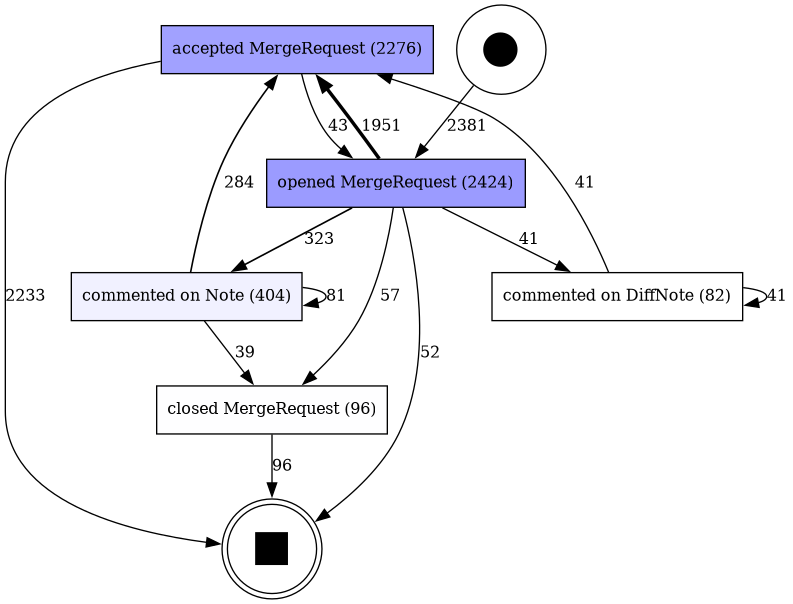

In [74]:
log_filtered_coverage = pm.filter_variants_by_coverage_percentage(log, 0.01)

dfg_comm, start_comm, end_comm = pm.discover_dfg(log_filtered_coverage)

pm.save_vis_dfg(dfg_comm, start_comm, end_comm, 'cut_dfg.png')

pm.view_dfg(dfg_comm, start_comm, end_comm)

In [86]:
gtk3_mask = log_filtered_coverage['case:trace_name'].str.lower().str.contains('gtk3')

log_gtk_3 = log_filtered_coverage[gtk3_mask]
log_gtk_4 = log_filtered_coverage[~gtk3_mask]

/home/gorg/Documents/Dev/mitsyuk/gtk-research-project/venv/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/home/gorg/Documents/Dev/mitsyuk/gtk-research-project/venv/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


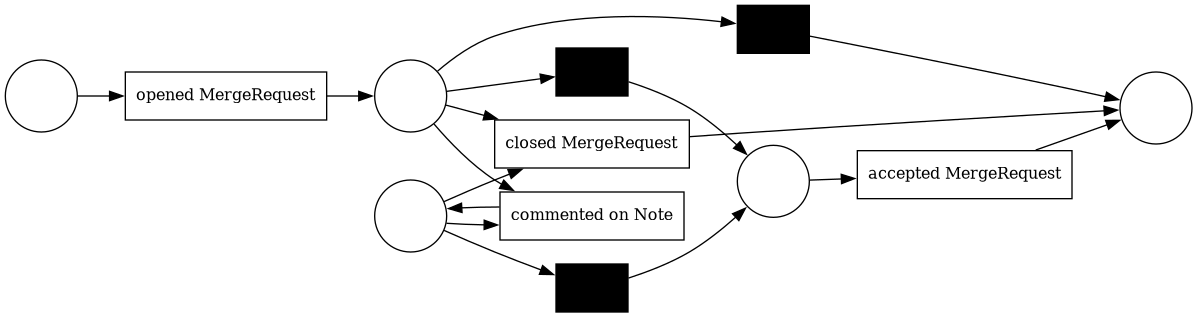

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

(0.5925925925925926, 27)

In [102]:
he3_net, he3_im, he3_fm = pm.discover_petri_net_heuristics(log_gtk_3)

pm.write_pnml(he3_net, he3_im, he3_fm, "gtk3.pnml")

pm.view_petri_net(he3_net)
pm.save_vis_petri_net(he3_net, he3_im, he3_fm, "gtk3.png")

replayed_traces = pm.conformance_diagnostics_token_based_replay(log_gtk_3, he3_net, he3_im, he3_fm)

replay_fits = list(map(lambda x: int(x['trace_fitness']), replayed_traces))
avg_replay = sum(replay_fits) / len(replay_fits)
avg_replay, len(replay_fits)

In [101]:
he4_net, he4_im, he4_fm = pm.discover_petri_net_heuristics(log_gtk_4)

pm.write_pnml(he4_net, he4_im, he4_fm, "gtk4.pnml")

pm.view_petri_net(he4_net)
pm.save_vis_petri_net(he4_net, he4_im, he4_fm, "gtk4.png")

replayed_traces = pm.conformance_diagnostics_token_based_replay(log_gtk_4, he4_net, he4_im, he4_fm)

replay_fits = list(map(lambda x: int(x['trace_fitness']), replayed_traces))
avg_replay = sum(replay_fits) / len(replay_fits)

avg_replay, len(replay_fits)

/home/gorg/Documents/Dev/mitsyuk/gtk-research-project/venv/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/home/gorg/Documents/Dev/mitsyuk/gtk-research-project/venv/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

(0.8249787595581988, 2354)

/tmp/ipykernel_140977/400067613.py:3: DeprecatedWarning: discover_dfg is deprecated as of 2.3.0 and will be removed in 2.4.0. this method will be replaced by the discover_dfg_typed function(). Please adapt your code to use pm4py.discover_dfg_typed()
  dfg_cov, start_cov, end_cov = pm.discover_dfg(log_cov_perf)
/home/gorg/Documents/Dev/mitsyuk/gtk-research-project/venv/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


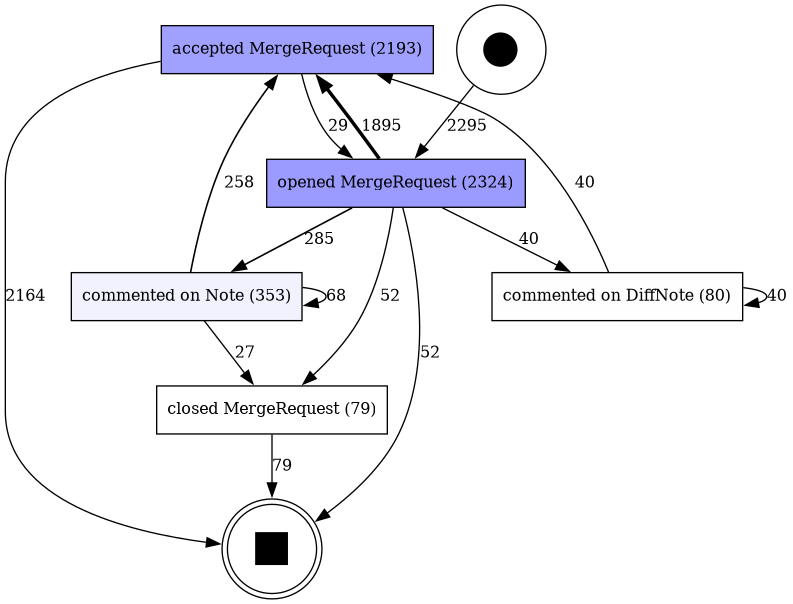

In [89]:
log_cov_perf = pm.filter_case_performance(log_filtered_coverage, 0, 864000)

dfg_cov, start_cov, end_cov = pm.discover_dfg(log_cov_perf)

pm.save_vis_dfg(dfg_cov, start_cov, end_cov, 'perf_dfg.png')

pm.view_dfg(dfg_cov, start_cov, end_cov)

/home/gorg/Documents/Dev/mitsyuk/gtk-research-project/venv/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/home/gorg/Documents/Dev/mitsyuk/gtk-research-project/venv/lib/python3.8/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


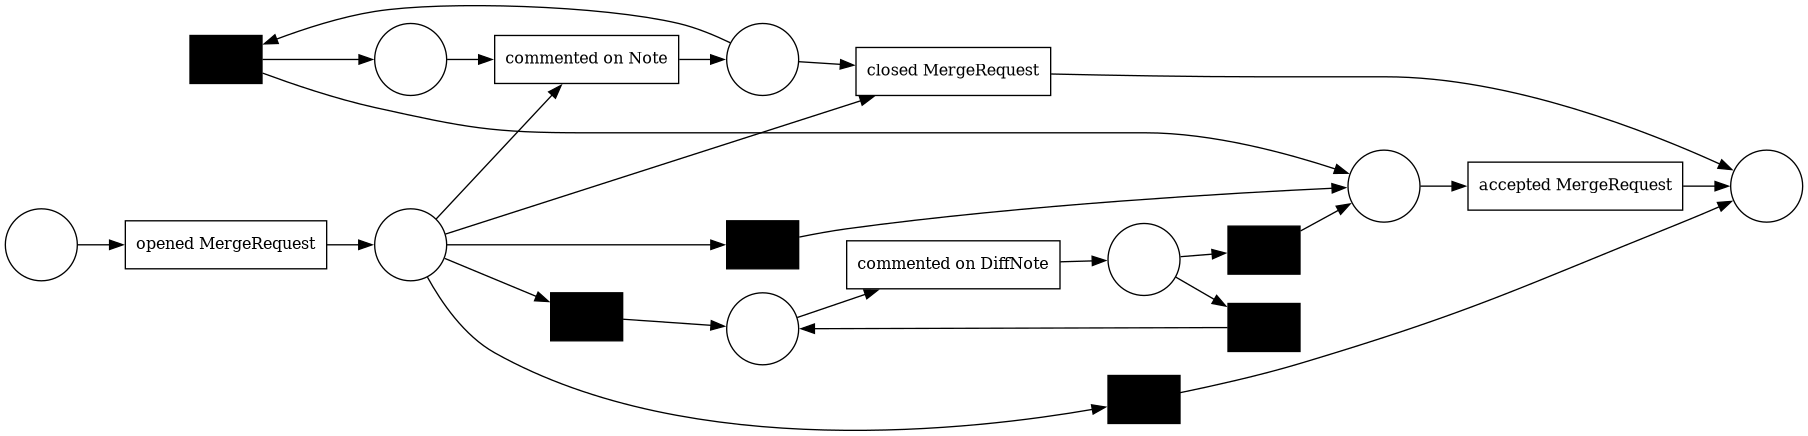

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

(0.8405228758169935, 2295)

In [100]:
heperf_net, heperf_im, heperf_fm = pm.discover_petri_net_heuristics(log_cov_perf)

pm.write_pnml(heperf_net, heperf_im, heperf_fm, "perf.pnml")

pm.view_petri_net(heperf_net)
pm.save_vis_petri_net(heperf_net, heperf_im, heperf_fm, "perf.png")

replayed_traces = pm.conformance_diagnostics_token_based_replay(log_cov_perf, heperf_net, heperf_im, heperf_fm)

replay_fits = list(map(lambda x: int(x['trace_fitness']), replayed_traces))
avg_replay = sum(replay_fits) / len(replay_fits)
avg_replay, len(replay_fits)

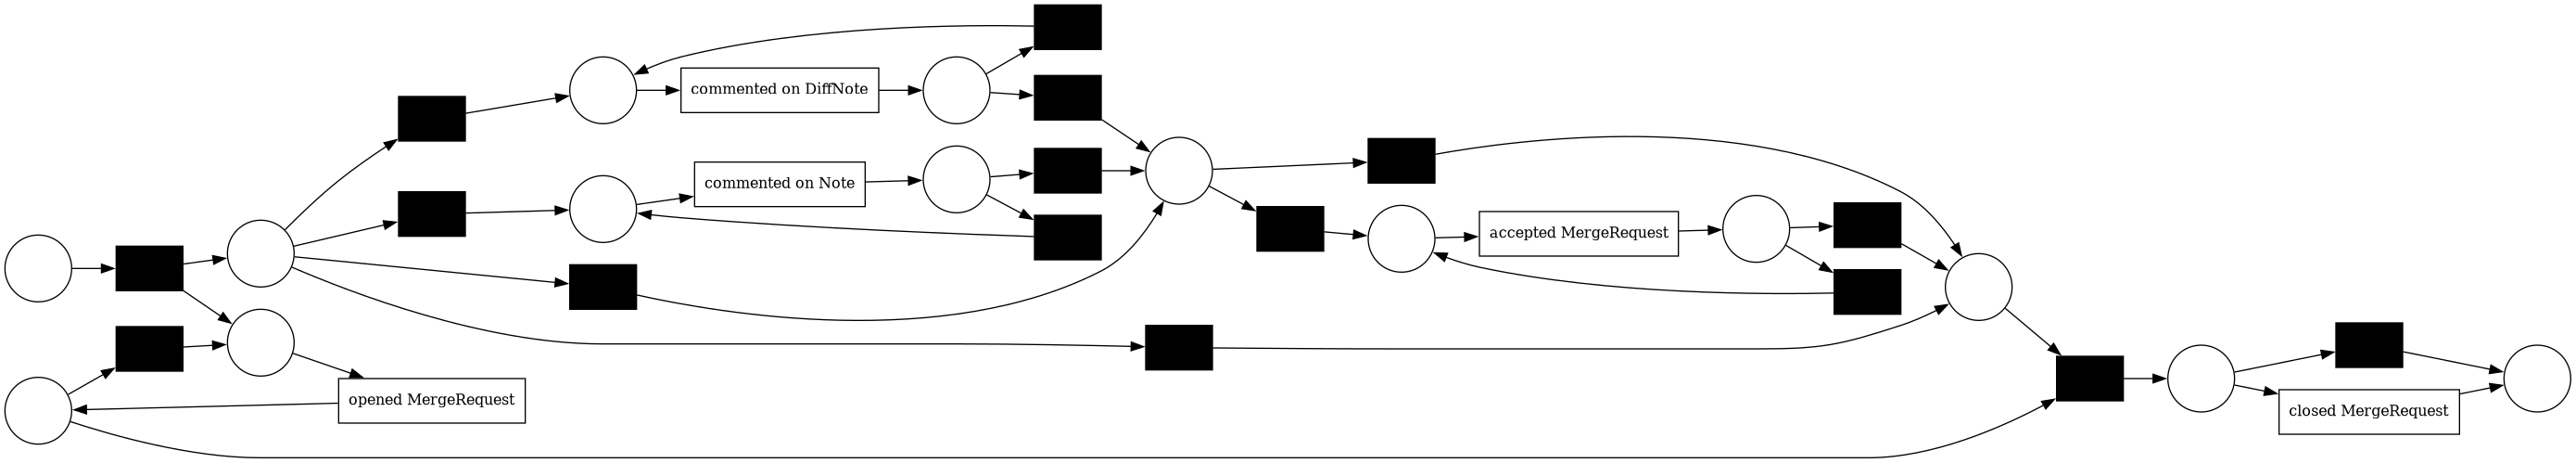

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

(1.0, 2354)

In [99]:
ind4_net, ind4_im, ind4_fm = pm.discover_petri_net_inductive(log_gtk_4)

pm.write_pnml(ind4_net, ind4_im, ind4_fm, "gtk4_ind.pnml")

pm.view_petri_net(ind4_net)
pm.save_vis_petri_net(indperf_net, indperf_im, indperf_fm, "gtk4_ind.png")

replayed_traces = pm.conformance_diagnostics_token_based_replay(log_gtk_4, ind4_net, ind4_im, ind4_fm)

replay_fits = list(map(lambda x: int(x['trace_fitness']), replayed_traces))
avg_replay = sum(replay_fits) / len(replay_fits)

avg_replay, len(replay_fits)

In [98]:
ind3_net, ind3_im, ind3_fm = pm.discover_petri_net_inductive(log_gtk_3)

pm.write_pnml(ind3_net, ind3_im, ind3_fm, "gtk3_ind.pnml")

pm.view_petri_net(ind3_net)
pm.save_vis_petri_net(indperf_net, indperf_im, indperf_fm, "gtk3_ind.png")

replayed_traces = pm.conformance_diagnostics_token_based_replay(log_gtk_3, ind3_net, ind3_im, ind3_fm)

replay_fits = list(map(lambda x: int(x['trace_fitness']), replayed_traces))
avg_replay = sum(replay_fits) / len(replay_fits)

avg_replay, len(replay_fits)

replaying log with TBR, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

(1.0, 27)

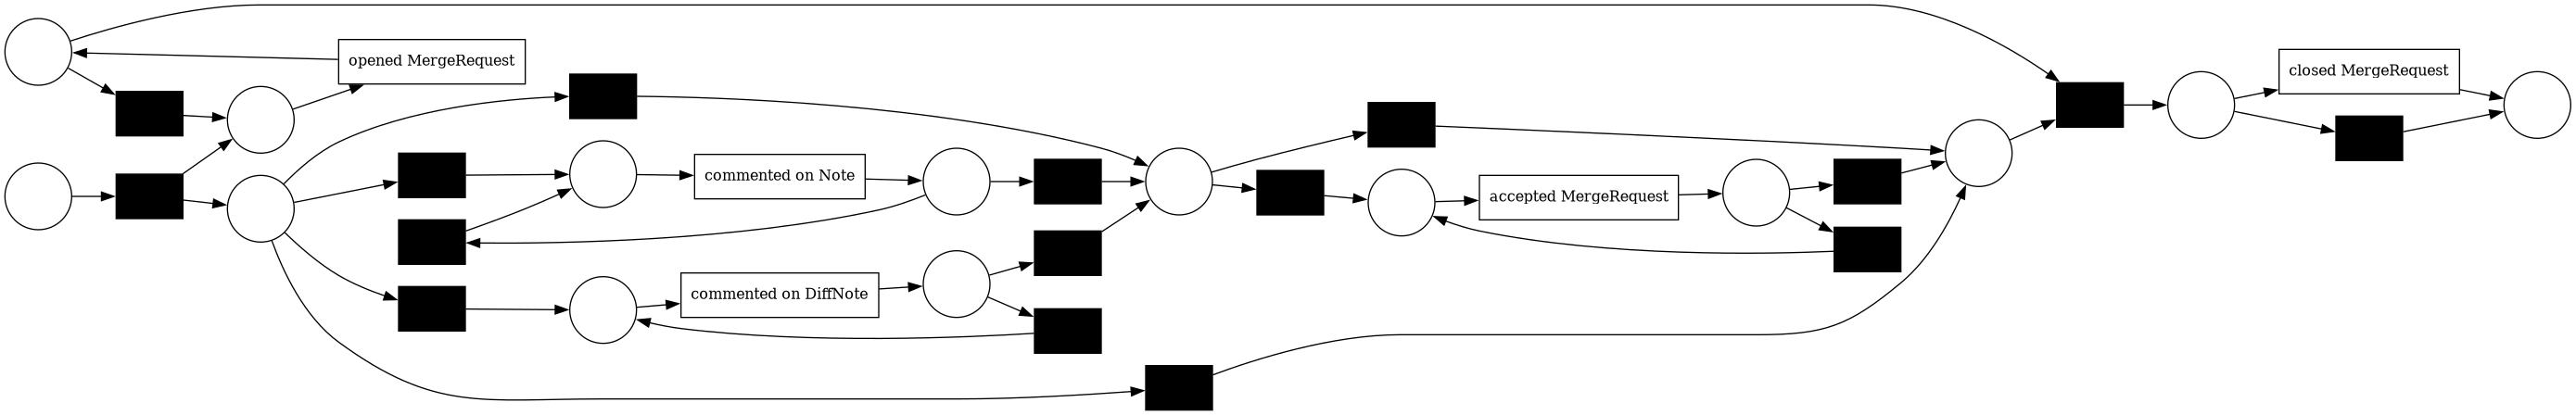

replaying log with TBR, completed variants ::   0%|          | 0/8 [00:00<?, ?it/s]

(1.0, 2295)

In [97]:
indperf_net, indperf_im, indperf_fm = pm.discover_petri_net_inductive(log_cov_perf)

pm.write_pnml(indperf_net, indperf_im, indperf_fm, "perf_ind.pnml")

pm.view_petri_net(indperf_net)
pm.save_vis_petri_net(indperf_net, indperf_im, indperf_fm, "perf_ind.png")

replayed_traces = pm.conformance_diagnostics_token_based_replay(log_cov_perf, indperf_net, indperf_im, indperf_fm)

replay_fits = list(map(lambda x: int(x['trace_fitness']), replayed_traces))
avg_replay = sum(replay_fits) / len(replay_fits)

avg_replay, len(replay_fits)